# Coursework 2 - Neural Networks and Unsupervised Learning

__Name__: Georgios Alevras <br> __CID__: 01531221 <br> __Date__: 25/03/2022

<a name="outline"></a>

## Outline

- [Preliminaries](#preliminaries): Exploratory Data Analysis
- [Task 1](#task-1): Neural Networks
  - [1.1](#q11) Multi-Layer Perceptron (MLP)
  - [1.2](#q12) Convolutional Neural Network (CNN)
- [Task 2](#task-2): Unsupervised Learning
  - [2.1](#q21) Dimensionality Reduction and Clustering of a Subset of the Fashion-MNIST Image Data
  - [2.2](#q22) Clustering of the Feature Matrix
  - [2.3](#q23) Graph-Based Analysis
- [Task 3](#task-3): Mastery Component
  - [3.1](#q31) Non-Negative Matrix Factorization (NMF) for Dimensionality Reduction
  - [3.2](#q32) Community Detection

<a name="preliminaries"></a>
# Preliminaries: Exploratory Data Analysis [^](#outline)

Firstly, we import all the necessary Python packages to perform and execute all calculations and computations.

In [1]:
# All packages used in this coursework are imported here.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Warning sign appears because I use Ubuntu and I haven't installed NVIDIA drivers so my GPU is not used.

2022-03-15 14:12:18.869906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 14:12:18.869944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We then import the dataset (both train and test data) using the function provided below, and perform an initial inspection of it, printing the shapes of each (x_train, y_train, x_test, y_test).

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)  # convert labels to categorical samples
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return (x_train, y_train, x_test, y_test)

In [3]:
x_train, y_train, x_test, y_test = load_data()  # import the data
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000, 10)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000, 10)


We see that the training data consists of $60,000$ images of dimensions (pixels) $28$ by $28$ as our input data, and $60,000$ output vectors of size $10$, denoting the class output (what garment is depicted by each image). Similarly, the test data consists of $10,000$ images of the same dimensions as our input data, and $10,000$ output vectors of size $10$, again, denoting the class output. To inspect further how they look, we depict a few examples below in *Figure 1*.

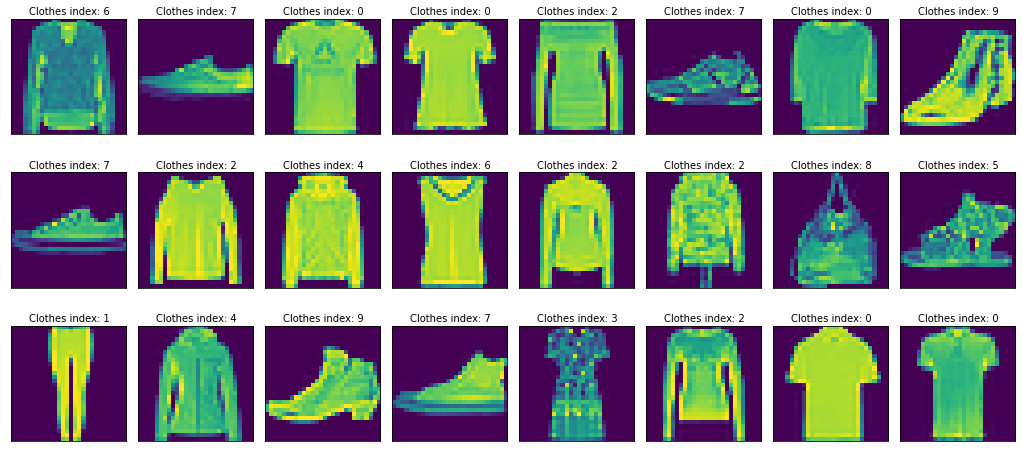

In [4]:
n_rows, n_cols = 3, 8
random_inx = np.random.choice(x_train.shape[0], n_rows * n_cols, replace=False)  # Selecting random data points from train data
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for n, i in enumerate(random_inx):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(x_train[i])  # Visualising image
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(4., -1.5, f'Clothes index: {np.argmax(y_train[i])}')  # Categorising output by index of output vector
plt.show()

**Figure 1:** A set of $24$ randomly selected images from the train dataset with their class category written above each image, denoted by the index of the output (category) vector it belongs to.

Finally, we can explore the class distribution of the data by obtaining the number of pictures that belong to each class, as shown below.

In [5]:
number_of_images_per_class_train = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}  # dictionary to hold occurence of each class (clothes type)
for i in range(len(y_train)):
    number_of_images_per_class_train[np.argmax(y_train[i])] += 1

number_of_images_per_class_test = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}  # dictionary to hold occurence of each class (clothes type)
for i in range(len(y_test)):
    number_of_images_per_class_test[np.argmax(y_test[i])] += 1

for i in range(len(number_of_images_per_class_train.keys())-1):  # loops through all classes to check they are all equivalent
    assert(number_of_images_per_class_train[i] == number_of_images_per_class_train[i+1])  # ensuring occurences of all classes are equivalent
    assert(number_of_images_per_class_test[i] == number_of_images_per_class_test[i+1])  # ensuring occurences of all classes are equivalent

print('Number of each category of clothes (train):', number_of_images_per_class_train)
print('Number of each category of clothes (test):', number_of_images_per_class_test)

Number of each category of clothes (train): {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
Number of each category of clothes (test): {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


We can see that the dataset is well-balanced, with an equal number of items belonging to each class both for our train and our test data, as was also verified from all assertions returning True. As a result of the dataset being well-balanced, we expect a baseline accuracy of 10% (1 over the number of classes), thus, if the MLP obtains an accuracy less than 10% the model would perform worse than picking at random, while any accuracy above 10% demonstrates that the MLP has at least some predictive power. Next, we build our Multi-Layer Perceptron.

<a name="task-1"></a>
# Task 1: Neural Networks [^](#outline)

<a name="q11"></a>

## 1.1 Multi-Layer Perceptron (MLP) [^](#outline)

<a name="q111"></a>

#### 1.1.1 Structure of MLP [^](#outline)

The Multi-Layer Perceptron (MLP) is a specific kind of feed-forward Artificial Neural Network (ANN) which consists of an input layer, an output layer and some number $L \in \mathbb{Z}^+$ of hidden layers, all of which are fully connected (all nodes in one layer are connected to all other nodes in the next layer). The MLP consists of the composition of many affine transformations, followed by the application of non-linear activation functions which operate element-wise. The architecture of the network can be fully described by the following equations:
$$\boldsymbol{h}^{(0)}:=\mathbf{x},$$
$$\boldsymbol{h}^{(k)}=\sigma \left( \mathbf{W}^{(k-1)}\boldsymbol{h}^{(k-1)} + \boldsymbol{b}^{(k-1)} \right), \quad k=1, \dots, L,$$
$$\hat{y} = \sigma_\text{out}\left( \boldsymbol{w}^{(L)} + b^{(L)} \right),$$

where $\mathbf{x} \in \mathbb{R}^D$ is an example input, $\boldsymbol{W}^{(k)} \in \mathbb{R}^{n_{k+1} \times n_k}$ is the matrix holding the weights between nodes of layer $n_k$ and $n_{k+1}$, $\boldsymbol{b}^{(k)} \in \mathbb{R}^{n_{k+1}}$ is the vector of biases added to the pre-activations $\boldsymbol{W}^{(k-1)}\boldsymbol{h}^{(k-1)} + \boldsymbol{b}^{(k-1)}$ at layer $k$, $\boldsymbol{h}^{(k)} \in \mathbb{R}^{n_{k}}$ is the vector of post-activation (or activation) values at layer $k$, $n_0 := D$, and $n_k$ is the number of nodes (neurons) at the $k$-th hidden layer. The activation function applied to the pre-activation values is $\sigma:\mathbb{R} \rightarrow \mathbb{R}$, while the activation function applied to the output values is $\sigma_\text{out}:\mathbb{R} \rightarrow \mathbb{R}$.

<a name="q112"></a>

#### 1.1.2 Error Backpropagation [^](#outline)

Using the set of equations described above we can perform a forward pass on a data-point (or a set of data-points) to predict its output. However, initially, all the weights and biases are random - the MLP has not been trained. Therefore, we want to learn the model to make good predictions. We achieve this via ***error backpropagation*** through:
1. the computation of the *stochastic gradient of the loss function* with respect to the parameters (weights and biases) of the MLP
2. the update of the MLP parameters using the already-computed gradients

Once we have computed all gradients for all model parameters we can update them according to *stochastic gradient descent* as such:

$$\theta_{t+1}=\theta_t - \eta\nabla_t L(\theta_t;D_m), \quad t \in \mathbb{N}_0,$$

for each iteration $t$, where $\eta$ is the *learning rate* and the loss value $L$ is evaluated using a randomly sampled subset of the training data $\mathcal{D}_m$ called a ***batch***, where $|\mathcal{D}_m| \ll |\mathcal{D}_\text{train}|$. The loss value $L$ is the average loss value from all data-points in a batch $\mathcal{D}_m$:

$$L(\theta_t; \mathcal{D}_m)=\frac{1}{M}\sum_{x_i, y_i \in \mathcal{D}_m} l(y_i, f_{\theta_t}(x_i)),$$

where $f_{\theta_t}(x_i)$ is the MLP model, and $L_i := l(y_i, f_{\theta_t}(x_i))$ is the per-example (data-point) loss. Therefore, our goal is to compute all gradients (using the chain rule):

$$\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}\frac{\partial{a_p^{(k+1)}}}{\partial{w_{pq}^{(k)}}},$$
$$\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}\frac{\partial{a_p^{(k+1)}}}{\partial{b_p^{(k)}}},$$

where $\boldsymbol{a}^{(k)}=\boldsymbol{W}^{(k-1)}\boldsymbol{h}^{(k-1)} + \boldsymbol{b}^{(k-1)}$ are the pre-activation values, which enable us to simplify the above equations as:

$$\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}h_q^{(k)} =: \delta_p^{(k+1)}h_q^{(k)},$$
$$\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}} =: \delta_p^{(k+1)},$$

where $\delta_p^{(k)} := \frac{\partial{L_i}}{\partial{a_p^{(k)}}}$. Next, we have to evaluate $\delta_p^{(k)}$:
$$\delta_p^{(k)}= \frac{\partial{L_i}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \frac{\partial{L_i}}{\partial{a_j^{(k+1)}}} \frac{\partial{a_j^{(k+1)}}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \delta_j^{(k+1)} \frac{\partial{a_j^{k+1}}}{\partial{a_p^{(k)}}}.$$

Knowing that: $a_j^{k+1}=\sum_{l=1}^{n_k} w_{jl}^{(k)}\sigma(a_l^{(k)}) + b_p^{(k)}$, we get: $\frac{\partial{a_j^{(k+1)}}}{\partial{a_p^{(k)}}}=w_{jp}^{(k)}\sigma'(a_p^{(k)})$, which means that:

$$\delta_p^k=\frac{\partial{L_i}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \delta_p^{(k+1)} \frac{\partial{a_j^{k+1}}}{\partial{a_p^{(k)}}}=\sigma'(a_p^{(k)}) \sum_{j=1}^{n_{k+1}} w_{jp}^{(k)}\delta_p^{(k+1)} = \sigma'(\boldsymbol{a}^{(k)})(\boldsymbol{W}^{(k)})^T \delta^{(k+1)},$$

where $\sigma'(\boldsymbol{a}^{(k)})=\text{diag}([\sigma'(a_p^{(k)})]_{p=1}^{n_k}).$ 

Therefore, in order for the MLP to learn, we need to:

1. Perform a forward pass of a batch of data-points through the MLP, computing and storing all pre-activations $\boldsymbol{a}^{(k)}$ and post-activations $\boldsymbol{h}^{(k)}$
2. Evaluate the errors on the output layer, $\delta^{(L+1)}=\frac{\partial{L_i}}{\partial{\boldsymbol{a}^{L+1}}}$
3. Backpropagate the errors for each layer using $\delta^{(k)}=\sigma'(\boldsymbol{a}^{(k)})(\boldsymbol{W}^{(k)})^T \delta^{(k+1)}$
4. Use the errors to obtain the derivaties of the per-example loss values: $\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\delta_p^{(k+1)}h_q^{(k)}$, $\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\delta_p^{(k+1)}$
5. Update the MLP parameters using stochastic gradient descent: $\theta_{t+1}=\theta_t - \eta\nabla_t L(\theta_t;D_m)$

<a name="q113"></a>

#### 1.1.3 Architecture of MLP for this Task [^](#outline)

For this particular task we need to choose the architecture of the model; the number of hidden layers $L$, the number of nodes (neurons) in each layer (including the input and the output layers), the activation function $\sigma$, and the output activation function $\sigma_\text{out}$. Given the nature of our dataset, printed above, we naturally define the input layer to have $784 = 28 \times 28$ neurons, i.e., we flatten the 2D array of pixels for an image to get a 1D array which we define as $\boldsymbol{h}^0:=\boldsymbol{x}$, and we define our output layer to have $10$ neurons, one for each class. We then decide to have **5** hidden layers, each with $400$ neurons, and use the $\text{LeakyReLU}(x)$ as the activation function for all layers except the output layer, for which we use the softmax function:

$$\text{LeakyReLU}(x)=\begin{cases} x, \quad x>0\\ \alpha x, \:\:\:x<=0\end{cases},$$

where $\alpha$ is a constant (in this case $\alpha=0.01$), and

$$\hat{\boldsymbol{y}}_j:=\text{softmax}(\boldsymbol{a}^{(L+1)})_j=\frac{\text{exp}(a_j)}{\sum_i \text{exp}(a_i)},$$

where $\boldsymbol{a}^{(L+1)}$ are the pre-activation values at the output layer, where $\hat{\boldsymbol{y}}$ is the vector of predicted probabilities for each class for one data-point.

Finally, the loss value for this MLP is obtained using the categorical cross-entropy loss function $L_\text{CE}$, which is given by:

$$L_\text{CE}=-\sum_{c=1}^C y_c \log{\hat{y}_c}, \quad \text{for} \: C \in \mathbb{N}_0 +1 \: \text{classes},$$

where $y_c$ is the ground truth for class $c$ and $\hat{y}_c$ is the softmax probability for class $c$. In order to be able to perform ***back-propagation*** we must be able to use the derivative functions of the activation functions, which are:

$$\text{LeakyReLU'}(x)=\begin{cases} 1, \quad x>0\\ \alpha, \:\:\:\:x<=0\end{cases},\\$$
$$\text{softmax'}(\boldsymbol{a}^{(L+1)})_j=\begin{cases} y_j(1-y_j), \quad i=j\\ -y_j y_i, \quad\:\:\:\:\:\:\:i \neq j\end{cases}.$$

Blablablabla use chain rule, where.

A great result is that the combination of the categorical cross-entropy loss function with the softmax activation function $\sigma_\text{out}$ results in an MSE-style error $\delta$. More specifically: . Below is the derivation that demonstrates this point.

Swap all i's with j's.


The activation functions, their derivative functions and softmax are outlined below.

In [36]:
def leakyrelu(x, alpha=0.01):
    # Returns x if x>0 and alpha*x if x<=0
	return x*(x>alpha) + alpha*x*(x<=xlpha)

def leakyrelu_prime(x, alpha=0.01):
    # Returns 1 if x>0 and alpha if x<0
    return np.ones(x.shape)*(x>0) + alpha*(x<0)

def softmax(y):
    e = np.exp(y)  # exponentiates all output vectors y for each value in a batch
    sums = np.sum(e, axis=1)  # sums of each output vector y for each value in a batch
    return e*1/sums[:, np.newaxis]  # Divides exponentiated output vector y with corresponding sum

def cross_entropy(y, y_hat, e=1e-7):
    # Categorical cross-entropy used as loss function
    values = -y*np.log(y_hat+e)  # Small error added to avoid infinity / NaN issues
    return np.sum(values, axis=1)

Next, we 

In [37]:
class MLP():
    def __init__(self, mlp_configuration):
        self.config = mlp_configuration  # Configuration of MLP (# of neurons in each layer)
        self.hidden_layers = len(mlp_configuration) - 2  # Number of hidden layers
        # Weights between successive layers, initialised from a Gaussian
        self.weights = [np.random.normal(size=(mlp_configuration[k+1], mlp_configuration[k])) * np.sqrt(2./(mlp_configuration[k]+mlp_configuration[k+1])) for k in range(len(mlp_configuration)-1)]
        # Biases added to each layer to perform pre-activation
        self.biases = [np.zeros((mlp_configuration[k+1])) for k in range(len(mlp_configuration)-1)]
        self.a = [None for _ in range(len(mlp_configuration)-1)]  # Pre-activations
        self.h = [None for _ in range(len(mlp_configuration))]  # (Post) Activations
        self.d = [None for _ in range(len(mlp_configuration)-1)]  # Deltas - errors at each node
        self.grad_weights = [None for _ in range(len(mlp_configuration)-1)]  # Weights gradients
        self.grad_biases = [None for _ in range(len(mlp_configuration)-1)]  # Biases gradients
        self.batch_losses = []  # Will hold the batch (iteration) losses
        self.batch_accuracies = []  # Will hold the batch (iteration) accuracies
        self.epoch_losses = []  # Will hold the epoch losses
        self.epoch_accuracies = []  # Will hold the epoch accuracies
        self.test_epoch_losses = []  # Will hold the epoch-average test losses
        self.test_epoch_accuracies = []  # Will hold the epoch-average test accuracies

    def __str__(self):
        weights_shapes = [self.weights[i].shape for i in range(len(self.weights))]  # Shape of weights array
        biases_shapes = [self.biases[i].shape for i in range(len(self.biases))]  # Shape of biases array
        return "\nMLP Characteristics:\n--------------------\nMLP Configuration: {}\nWeights shapes: {} \
            \nBiases shapes: {}\n\n".format(self.config, weights_shapes, biases_shapes)
    
    def forward_pass(self, x):
        self.h[0] = x  # Initialise first activations to input nodes (input data)
        for k in range(self.hidden_layers):  # Loop through all hidden layers
            self.a[k] = np.matmul(self.weights[k], self.h[k].T).T + self.biases[k]  # Compute pre-activations
            self.h[k+1] = leakyrelu(self.a[k])  # Apply activation function (leaky RELU) to get (post) activations
        self.a[-1] = np.matmul(self.weights[-1], self.h[-2].T).T + self.biases[-1]  # Compute pre-activations for output layer
        self.h[-1] = softmax(self.a[-1])  # Apply output-activation function (softmax) to get output nodes

    def backpropagate_errors(self, y):
        self.d[-1] = self.h[-1] - y  # Get output errors using softmax and categorical cross-entropy
        for k in reversed(range(self.hidden_layers)):  # Loop through all hidden layers in reverse
            self.d[k] = leakyrelu_prime(self.a[k]) * (self.weights[k+1].T @ self.d[k+1].T).T  # Backpropagate errors
            
    def update_params(self, learning_rate):
        for k in range(self.hidden_layers+1):  # Loop through all layers (except output)
            # Taking the average weight gradients over all inputs in a batch (outer product for 3D matrix)
            self.grad_weights[k] = np.matmul(self.d[k][:, :, np.newaxis], self.h[k][:, np.newaxis, :]).mean(axis=0)
            self.grad_biases[k] = self.d[k].mean(axis=0)  # Compute biases gradients using deltas
            self.weights[k] -= learning_rate*self.grad_weights[k]  # Update weights with learning rate
            self.biases[k] -= learning_rate*self.grad_biases[k]  # Update biases with learning rate

    def make_prediction(self, x, y_t):
        # Perform a forward pass to obtain a prediction on a batch of input data
        values = x  # Initialise first activations to input nodes (input data)
        for k in range(self.hidden_layers):  # Loop through all hidden layers
            values = np.matmul(self.weights[k], values.T).T + self.biases[k]  # Compute pre-activations
            values = leakyrelu(values)  # Apply activation function (leaky RELU) to get (post) activations
        final_values = np.matmul(self.weights[-1], values.T).T + self.biases[-1]  # Compute pre-activations for output layer
        final_values = softmax(final_values)  # Apply output-activation function (softmax) to get output nodes
        
        crs_entr = cross_entropy(y_t, final_values)  # Obtain loss value (categorical cross-entropy)
        prediction = np.zeros((final_values.shape))  # Array to convert probabilities to class prediction
        successful = np.zeros((final_values.shape[0]))  # Array to hold successful predictions for each datum
        for p in range(len(prediction)):  # Looping through all data-points in a batch
            prediction[p][np.argmax(final_values[p])] = 1  # Assign the predicted class to the highest probability
            # Assign as succesful prediction if it the same as that of the ground truth
            successful[p] = [1 if np.all(prediction[p] == y_t[p]) else 0][0]
        return np.mean(crs_entr), np.mean(successful)  # Return batch-average loss and accuracy

    def train(self, x_train, y_train, x_test, y_test, learning_rate=1e-3, batch_size=256, epochs=40):
        for e in range(epochs):
            p = np.random.permutation(len(x_train))  # Randomise indices of all data
            random_indices = [p[idx:idx+batch_size] for idx in range(0, len(p), batch_size)]  # Create random batch indices
            for rnd_idx in random_indices:  # Loop through batch indices
                x_batch, y_batch = x_train[rnd_idx], y_train[rnd_idx]  # Create batches of X and Y data
                self.forward_pass(x_batch)  # Perform forward pass on batch of data
                self.backpropagate_errors(y_batch)  # Perform backprogatation of errors on batch of data
                self.update_params(learning_rate)  #  Update MLP parameters (weights, biases) after backpropagation
                batch_loss, batch_accuracy = self.make_prediction(x_batch, y_batch)  # Obtain batch-average loss and accuracy
                self.batch_accuracies.append(batch_accuracy)
                self.batch_losses.append(batch_loss)
            
            epoch_loss, epoch_accuracy = self.make_prediction(x_train, y_train)  # Obtain epoch loss and accuracy on train data
            self.epoch_losses.append(epoch_loss)
            self.epoch_accuracies.append(epoch_accuracy)
            test_loss, test_accuracy = self.make_prediction(x_test, y_test)  # Obtain epoch loss and accuracy on test data
            self.test_epoch_losses.append(test_loss)
            self.test_epoch_accuracies.append(test_accuracy)
            print('Completed:', str(e+1) + '/' + str(epochs))


    def plot(self, learning_rate=1e-3, batch_size=256, epochs=40):
        plt.figure(1)
        plt.plot(np.linspace(1, len(self.epoch_accuracies), len(self.epoch_accuracies)), self.epoch_accuracies, color='blue', label='Train Data')
        plt.plot(np.linspace(1, len(self.test_epoch_accuracies), len(self.test_epoch_accuracies)), self.test_epoch_accuracies, color='orange', label='Test Data')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.xlim(1, len(self.epoch_accuracies))
        plt.ylim(0, 1)
        plt.legend()
        plt.savefig('epoch_accuracy_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.png')
        
        plt.figure(2)
        plt.plot(np.linspace(1, len(self.epoch_losses), len(self.epoch_losses)), self.epoch_losses, color='blue', label='Train Data')
        plt.plot(np.linspace(1, len(self.test_epoch_losses), len(self.test_epoch_losses)), self.test_epoch_losses, color='orange', label='Test Data')
        plt.xlabel('Epoch')
        plt.ylabel('Categorical Cross-Entropy')
        plt.xlim(1, len(self.epoch_losses))
        plt.legend()
        plt.savefig('epoch_loss_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.png')

        plt.figure(3)
        plt.plot(np.linspace(1, len(self.batch_accuracies), len(self.batch_accuracies)), self.batch_accuracies, color='blue', label='Train Data - Batch Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.xlim(0, len(self.batch_accuracies))
        plt.ylim(0, 1)
        plt.legend()
        plt.savefig('batch_accuracy_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.png')
        
        plt.figure(4)
        plt.plot(np.linspace(1, len(self.batch_losses), len(self.batch_losses)), self.batch_losses, color='orange', label='Train Data - Batch Iterations')
        plt.xlabel('Iteration')
        plt.ylabel('Categorical Cross-Entropy')
        plt.xlim(0, len(self.batch_losses))
        plt.legend()
        plt.savefig('batch_loss_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.png')

        plt.show()

<a name="q12"></a>
## 1.2 Convolutional Neural Network (CNN) [^](#outline)

<a name="task-2"></a>

# Task 2: Unsupervised Learning [^](#outline)

<a name="q21"></a>

## 2.1 Dimensionality Reduction and Clustering of a Subset of the Fashion-MNIST Image Data [^](#outline)

<a name="q22"></a>

## 2.2 Clustering of the Feature Matrix [^](#outline)

<a name="q23"></a>

## 2.3 Graph-Based Analysis [^](#outline)

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

<a name="q31"></a>

## 3.1 Non-Negative Matrix Factorization (NMF) for Dimensionality Reduction [^](#outline)

<a name="q32"></a>

## 3.2 Community Detection [^](#outline)